## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках эксперимента

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [54]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

### Функция get_bootstrap
* Есть две выборки из генеральной совокупности - экспериментальная и контрольная
* Из двух выборок начинаем делать бустрапированные подвыборки и для каждой подвыборки рассчитываем разницу средних (и добавляем в корзиночку, чтобы потом гистограммку нарисовать)
* Бутстрап показывает распределение разницы средних значений подвыборок из наших исходных выборок

In [2]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Демонстрация работы бутстрапа

In [3]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [4]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

  0%|          | 0/1000 [00:00<?, ?it/s]

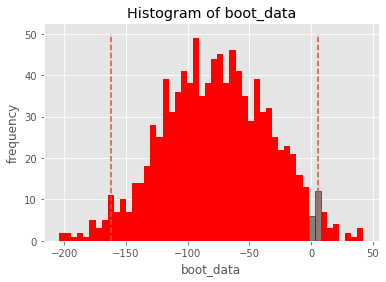

In [5]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [6]:
booted_data["p_value"] # альфа

0.07704553867678232

In [7]:
booted_data["quants"] # ДИ

,0
0.025,-161.943418
0.975,5.328283


In [8]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [9]:
data_ab.head()

,Unnamed: 0,value,experimentVariant
0,1,9.773113,Treatment
1,2,9.311246,Treatment
2,3,11.172828,Treatment
3,4,11.624510,Treatment
4,5,10.462331,Treatment


In [10]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [11]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

,value
experimentVariant,
Control,500
Treatment,50


In [12]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,10.367236


In [13]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.420193


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

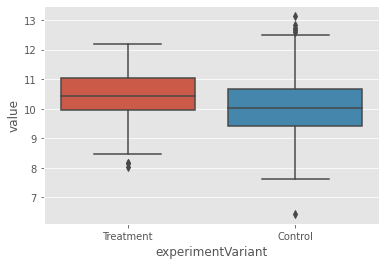

In [14]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

### Задача = сравнить данные распределения <br>

* **Treatment** = исследование

C:\Users\grish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

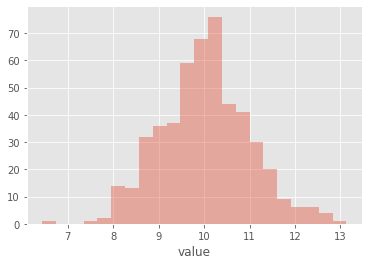

In [15]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

<AxesSubplot:xlabel='value'>

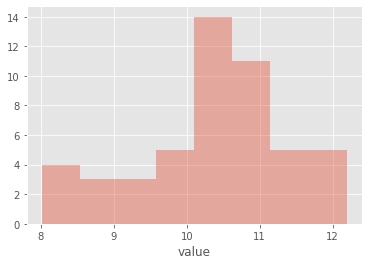

In [16]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

**И Манна-Уитни, и независимый Т-Тест дадут нам значимые результаты, но их значимость будет отличаться на порядок!** </br>
Это то, зачем мы здесь собрались

In [17]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=15492.0, pvalue=0.005236419587596797)

In [19]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.331858965573001, pvalue=0.020069539127355422)

Если мы попробуем поставить порог значимости p-value = 0.01, что очень часто используется как альтернативный порог принятия решений, то получится, что один статистический критерий показывает, что различия стат. значимы, а другой статистический критерий говорит, что различия стат. не значимы

T-test далеко не всегда требует, чтобы распределение признака было нормальным. </br>
Если размер выборки большой, то с T-test будет всё ОК

Критерий **Манна-Уитни** очень тяжело интерпретировать в терминах, понятных для заказчика, для бизнеса или для нас самих

  0%|          | 0/1000 [00:02<?, ?it/s]

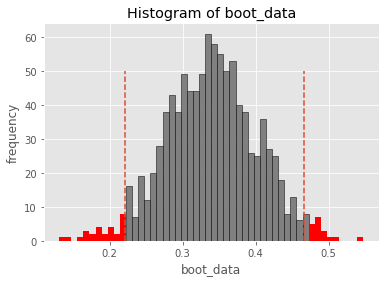

{'boot_data': [0.18776922743289298,
  0.2743838675211076,
  0.3909727989808199,
  0.3904828832226607,
  0.31485717935864965,
  0.3069757794930818,
  0.3362924106925129,
  0.24950386781883185,
  0.28549502999860166,
  0.3264786929742884,
  0.3346640724381806,
  0.20350194545007164,
  0.36711279749907455,
  0.375955783001078,
  0.4763711687140301,
  0.21050188748730733,
  0.39965962726509974,
  0.21706371747252265,
  0.3205050287524081,
  0.2999072255449677,
  0.3451589979116176,
  0.3711652313496434,
  0.487194465404953,
  0.38663407840311725,
  0.4291399125597985,
  0.3559036189255172,
  0.3610108676411262,
  0.2950572590683744,
  0.31109350067948716,
  0.35442805077715583,
  0.34979957789697175,
  0.3667140741186572,
  0.2904463981998923,
  0.42686031890116566,
  0.341652008102179,
  0.35767692844111876,
  0.3436850660528668,
  0.4083918267424844,
  0.28116169911536243,
  0.3747434483761955,
  0.39999030352400655,
  0.35416193032476184,
  0.3626667443237265,
  0.3108938088118633,
  0.

In [20]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

  0%|          | 0/1000 [00:00<?, ?it/s]

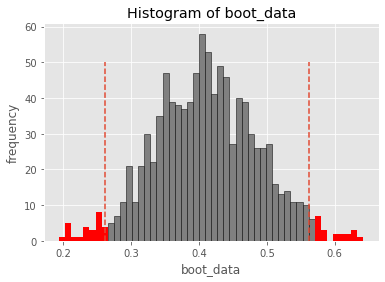

{'boot_data': [0.4759590488007044,
  0.44919718704470046,
  0.3980850896149004,
  0.3608391225914547,
  0.42894577490037467,
  0.5177598200697888,
  0.46535184538277985,
  0.5216242095347852,
  0.42673026232804023,
  0.62161333416711,
  0.6044745340126507,
  0.38857443843664985,
  0.4355556135150298,
  0.29364374617110034,
  0.4142134813097198,
  0.41144980025370037,
  0.31347990476915477,
  0.48392564486073475,
  0.446982442825651,
  0.41460889208093565,
  0.4515132516660145,
  0.34388991400254554,
  0.42707226369779505,
  0.3834338893270992,
  0.30457351226240004,
  0.40081608397083457,
  0.454579907957104,
  0.4031289695497815,
  0.4441734506115651,
  0.4405413255045154,
  0.37475009229738454,
  0.29152425843473484,
  0.3906667841172,
  0.31474915236985,
  0.43414578468348,
  0.472984033859575,
  0.5017382678905644,
  0.4432384102167397,
  0.3638246107155503,
  0.29613859624205485,
  0.2521697111478156,
  0.4174575927235349,
  0.40600335444540026,
  0.4363476563528996,
  0.424638008

In [21]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

**Вывод:** </br>
Доверительный интервал для разницы медиан не включает нолик (косвенная оценка p-value). Это означает, что медианы стат. значимо различаются

In [22]:
#p-value в конце списка
5.4687657931866705e-08 < 0.0000002

True

**Выводы:** </br>
1. Когда мы говорим про относительно небольшие выборки, то T-test лучше не использовать
2. Если выборки небольшие, но они точно прошли различия на нормальность распределения, на гомогенность дисперсии, то T-test даст такие же стат. различия, как Манна-Уитни
3. Если хоть что-то "поплыло", то Манна-Уитни даст более надёжный результат
4. Если выборки большие, то T-test становится относительно робастым и можно верить и ему, но это требует дополнительной **подготовки:**
* В индустрии берут интересующую метрику
* Сначала просто моделируют данные, прогоняют бесконечно вымышленные А/А эксперименты
* Применяют T-test, чтобы доказать его робастость
5. Бутстрап хорошо работает, когда мы уверены, что наша выборка действительно репрезентативна и отражает генеральную совокупность, и когда мы не хотим особо завязываться на каких-то мат. требованиях, которые накладывают на ограничения стат. тестов (гомогенность дисперсий, нормальность распределения)
6. Но с маленькой нерепрезентативной выборкой бутстрап тоже не поможет

In [24]:
ads_data = pd.read_csv('ads_data.csv.zip')

In [34]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .reset_index()

event,ad_id,click,view
0,3,9.0,490.0
1,2132,1.0,95.0
2,2276,2.0,1454.0
3,2475,NaN,132.0
4,2643,3.0,286.0
...,...,...,...
350,121941,1.0,640.0
351,121943,15.0,1722.0
352,122042,1.0,155.0
353,122063,1.0,260.0
